# Forecasting JP Morgan's Price Movement Using Machine Learning

**CCNY CSC 59866 Senior Design - Machine Learning** <br>
**By: Andrey Goryuk**

## Table of Contents
* [Executive Summary](#executive_summ)
* [Data Retrieval](#data_retrieval)
* [Adding Additional Features](#add_feat)
* [Data Exploration and Visualization](#data_explore)
* [Data Preprocessing](#data_preprocess)
* [Training Models](#data_training) <br> 
    a. [Linear Model](#lin_model) <br>
    b. [Random Forest Model](#random_forest_model) <br>
    c. [Neural Network](#neural_network_model) <br>
* [Measuring Performance](#data_perfor) <br>
    a. [ROC Curves](#roc_curves) <br>
    b. [Confusion Matrices And Accuracy](#conf_matrix) <br>
* [Assessing Interpretability ](#data_interp)<br>
    a. [Feature Importance](#feature_coeff) <br>
    b. [Shapley Plots](#shapley_plots) <br>
* [Conclusion](#conclusion)

## Executive Summary <a id='executive_summ'></a>

Stock market prediction is usually done with one of two prominent paradigms: *fundamental* or *technical* analysis. Fundamental analysis involves looking at a company's intrinsic value through various micro and macro economic factors such as balance sheets, market and consumer sentiment, sector performance, and current events. Technical analysis, on the other hand, focuses on a stock's previous prices, volume, and other numeric measurements including historic patterns. It is in this area that machine learning excels in that it can leverage it's immense power to study and understand numeric trends with the ultimate goal of predicting a stock's next move. <br>
This project attempts to predict whether or not JP Morgan's stock price will hit a higher high price in the next trading day. In order to do so, 3 machine learning models will be trained on over 6 years of JP Morgan's daily stock data. The models trained are a logistic regression, random forest classifier, and neural network. In addition to the raw data available, various additional features will be encoded, some of which are widely used technical indicators. The data will be visualized and preprocessed before being fed into the 3 models. After training, these models will be put to the test on over 2 years of daily trading data to assess performance. The models' interpretability will also be analysed to see which features played the greatest roles in the models' predictions. <br>
Of the three models, the logistic regression performed the best achieving around 65% accuracy while random forest and neural networks hovered around 50% accuracy. In looking at the confusion matrices of the three models, it is seen that the random forest classifier and neural network struggle in correctly predicting when the stock goes up achieving low true positive rates, an area where the logistic regression model significantly outperforms them. This is despite all three models having fairly similar true negative rates.

## Data Retrieval <a id='data_retrieval'></a>

I will be retreiving the daily stock information of JP Morgan from 2012 to 2019. The stock data was downloaded from [Yahoo Finance](https://finance.yahoo.com/quote/JPM/history?period1=1325289600&period2=1577750400&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true) with the desired period. The file was saved locally as "JPM_Daily_Stock_Price.csv" in the 'Data' directory. The link above is the exact data used with the filters applied.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from sklearn.metrics import plot_roc_curve, roc_curve, roc_auc_score, accuracy_score
import shap

In [2]:
jpm_data = pd.read_csv('/Data/JPM_Daily_Stock_Price.csv')
jpm_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-03,34.060001,35.189999,34.009998,34.980000,27.021782,44102800
1,2012-01-04,34.439999,35.150002,34.330002,34.950001,27.192959,36571200
2,2012-01-05,34.709999,35.919998,34.400002,35.680000,27.760937,38381400
3,2012-01-06,35.689999,35.770000,35.139999,35.360001,27.511944,33160600
4,2012-01-09,35.439999,35.680000,34.990002,35.299999,27.465273,23001800


In [3]:
print("Original Columns ::", jpm_data.columns)
print("Shape of data ::", jpm_data.shape)
print("First Date ::", jpm_data.iloc[0]['Date'])
print("Last Date ::", jpm_data.iloc[len(jpm_data) - 1]['Date'])

jpm_data[jpm_data.isna().any(axis=1)], jpm_data[jpm_data.isnull().any(axis=1)]

Original Columns :: Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
Shape of data :: (2011, 7)
First Date :: 2012-01-03
Last Date :: 2019-12-30


(Empty DataFrame
 Columns: [Date, Open, High, Low, Close, Adj Close, Volume]
 Index: [],
 Empty DataFrame
 Columns: [Date, Open, High, Low, Close, Adj Close, Volume]
 Index: [])

We can see that our data has the following columns: date, open price, daily high price, daily low price, close price, adjusted close price, and daily volume. Our data also has 2011 rows with the first date being January 3rd 2012 and the last being December 30th 2019. A quick check shows their are no NANs or nulls in the dataframe.

## Adding Additional Features <a id='add_feat'></a>

### Trivial Attributes

The first few attributes that I will be adding are fairly trivial. They are neccessary for training the model and to be used in calculating the non-trivial ones.

The first is a lagged attribute being the previous day's close. This will be used to calculate daily change and daily percentage change.

In [4]:
jpm_data['Prev_Close'] = jpm_data['Close'].shift(1)

The next cell calculates the difference between today's close and yesterday's close in dollar value.

In [5]:
jpm_data['Daily_Change'] = jpm_data['Close'] - jpm_data['Prev_Close'] 

The next cell calculates the difference between today's close and yesterday's close as a percentage.

In [6]:
jpm_data['Daily_Change_Percent'] = (jpm_data['Close'] - jpm_data['Prev_Close'])/(jpm_data['Prev_Close'])

The next cell calculates the high-low difference for every row.

In [7]:
jpm_data['H_L_Diff'] = jpm_data['High'] - jpm_data['Low'] 

In [8]:
jpm_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Prev_Close,Daily_Change,Daily_Change_Percent,H_L_Diff
0,2012-01-03,34.060001,35.189999,34.009998,34.980000,27.021782,44102800,NaN,NaN,NaN,1.180001
1,2012-01-04,34.439999,35.150002,34.330002,34.950001,27.192959,36571200,34.980000,-0.029999,-0.000858,0.820000
2,2012-01-05,34.709999,35.919998,34.400002,35.680000,27.760937,38381400,34.950001,0.729999,0.020887,1.519996
3,2012-01-06,35.689999,35.770000,35.139999,35.360001,27.511944,33160600,35.680000,-0.319999,-0.008969,0.630001
4,2012-01-09,35.439999,35.680000,34.990002,35.299999,27.465273,23001800,35.360001,-0.060002,-0.001697,0.689998


Now, to create the target feature. The goal of this project is to determine whether the next day's high will be greater than today's high. As such we can, encode this by looking at the next day's high, using pd.shift, and entering a 1 if it is greater than today's high and a 0 if it is the same(highly unlikely) or less.

In [9]:
jpm_data['Next_High'] = np.where(jpm_data['High'].shift(-1) > jpm_data['High'], 1, 0)

In [10]:
jpm_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Prev_Close,Daily_Change,Daily_Change_Percent,H_L_Diff,Next_High
0,2012-01-03,34.060001,35.189999,34.009998,34.980000,27.021782,44102800,NaN,NaN,NaN,1.180001,0
1,2012-01-04,34.439999,35.150002,34.330002,34.950001,27.192959,36571200,34.980000,-0.029999,-0.000858,0.820000,1
2,2012-01-05,34.709999,35.919998,34.400002,35.680000,27.760937,38381400,34.950001,0.729999,0.020887,1.519996,0
3,2012-01-06,35.689999,35.770000,35.139999,35.360001,27.511944,33160600,35.680000,-0.319999,-0.008969,0.630001,0
4,2012-01-09,35.439999,35.680000,34.990002,35.299999,27.465273,23001800,35.360001,-0.060002,-0.001697,0.689998,1


### Non-trivial Attributes

The attributes that are added below are all technical stock indicators meaning they are derived from patterns and values of the stock's previous performance. The indicators below were selected from the research paper [*Predicting Stock Market Trends Using Machine learning and Deep Learning Algorithms Via Continuous and Binary Data*](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9165760). This paper assessed the ability of various machine learning techniques in predicting future movement, similar to goal of this project. The paper compared the performances of Decision Tree, Random Forest, Adaboost, XGBoost, SVC, Naive Bayes, KNN, Logistic Regression, and ANN machine learning models as well as two deep learning algorithms, RNN and LSTM. They utilized the continuous values from ten technical indicators as well as their binary conversion (+1 if the indicator suggested upward trend or -1 if the indicator suggested downward trend) as inputs to the models.

#### 7 Day Moving Average

The first attribute to be created is one that is a common technical indicator seen on most stock market charts. This attribute is called the moving average (MA). For the purpose of this project, I will be calculating the 7 day moving average for the stock's close. Furthermore, after finding the moving average, a trend indicator will be encoded. If today's close is higher than the 7 day moving average, this is an indication of an uptrend which is represented by a 1. If today's close is lower than the 7 day moving average, a 0 is encoded, indicative of a downtrend. <br>
*Sources*: [*Predicting Stock Market Trends Using Machine learning and Deep Learning Algorithms Via Continuous and Binary Data*](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9165760)

In [11]:
jpm_data['7_Day_MA'] = jpm_data.iloc[:,4].rolling(window=7).mean()

In [12]:
jpm_data['MA_Trend'] = np.where(jpm_data['Close'] > jpm_data['7_Day_MA'], 1, 0)

In [13]:
jpm_data.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,Prev_Close,Daily_Change,Daily_Change_Percent,H_L_Diff,Next_High,7_Day_MA,MA_Trend
0,2012-01-03,34.060001,35.189999,34.009998,34.980000,27.021782,44102800,NaN,NaN,NaN,1.180001,0,NaN,0
1,2012-01-04,34.439999,35.150002,34.330002,34.950001,27.192959,36571200,34.980000,-0.029999,-0.000858,0.820000,1,NaN,0
2,2012-01-05,34.709999,35.919998,34.400002,35.680000,27.760937,38381400,34.950001,0.729999,0.020887,1.519996,0,NaN,0
3,2012-01-06,35.689999,35.770000,35.139999,35.360001,27.511944,33160600,35.680000,-0.319999,-0.008969,0.630001,0,NaN,0
4,2012-01-09,35.439999,35.680000,34.990002,35.299999,27.465273,23001800,35.360001,-0.060002,-0.001697,0.689998,1,NaN,0
5,2012-01-10,36.070000,36.349998,35.759998,36.049999,28.048803,35972800,35.299999,0.750000,0.021246,0.590000,1,NaN,0
6,2012-01-11,35.799999,36.740002,35.660000,36.660000,28.523422,29852900,36.049999,0.610001,0.016921,1.080002,1,35.568571,1
7,2012-01-12,36.820000,37.049999,36.169998,36.849998,28.671261,39420700,36.660000,0.189998,0.005183,0.880001,0,35.835714,1
8,2012-01-13,35.259998,35.919998,35.130001,35.919998,27.947662,61571500,36.849998,-0.930000,-0.025237,0.789997,0,35.974285,0
9,2012-01-17,34.849998,35.680000,34.500000,34.910000,27.161823,55115100,35.919998,-1.009998,-0.028118,1.180000,1,35.864285,0


#### 7 Day Momentum

The next nontrivial feature to be created is the momentum of the stock. Momentum measures the velocity of price chnages and is calculated by continually taking the price difference over a fixed period. For this project, momentum will be measured over a 7 day period, taking the difference between today's closing price and the closing price 7 days ago. Momentum can help determine the strength of a trend with a value over 0 indicating an upward movement and below 0, a downward movement. Momentum is often graphed around the zero line and is considered to be an unbounded oscillator. <br>
*Sources*: [*Predicting Stock Market Trends Using Machine learning and Deep Learning Algorithms Via Continuous and Binary Data*](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9165760), [Investopedia](https://www.investopedia.com/terms/m/macd.asp), 
[Fidelity (MACD)](https://www.fidelity.com/viewpoints/active-investor/how-to-use-macd), [Fidelity (EMA)](https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/ema#:~:text=Exponential%20Moving%20Average%20(EMA)%20is,data%20that%20is%20more%20current.)

In [14]:
jpm_data['7_Day_MOM'] = jpm_data['Close'] - jpm_data['Close'].shift(5)

In [15]:
jpm_data['MOM_Trend'] = np.where(jpm_data['7_Day_MOM'] > 0, 1, 0)

In [16]:
jpm_data.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,Prev_Close,Daily_Change,Daily_Change_Percent,H_L_Diff,Next_High,7_Day_MA,MA_Trend,7_Day_MOM,MOM_Trend
0,2012-01-03,34.060001,35.189999,34.009998,34.980000,27.021782,44102800,NaN,NaN,NaN,1.180001,0,NaN,0,NaN,0
1,2012-01-04,34.439999,35.150002,34.330002,34.950001,27.192959,36571200,34.980000,-0.029999,-0.000858,0.820000,1,NaN,0,NaN,0
2,2012-01-05,34.709999,35.919998,34.400002,35.680000,27.760937,38381400,34.950001,0.729999,0.020887,1.519996,0,NaN,0,NaN,0
3,2012-01-06,35.689999,35.770000,35.139999,35.360001,27.511944,33160600,35.680000,-0.319999,-0.008969,0.630001,0,NaN,0,NaN,0
4,2012-01-09,35.439999,35.680000,34.990002,35.299999,27.465273,23001800,35.360001,-0.060002,-0.001697,0.689998,1,NaN,0,NaN,0
5,2012-01-10,36.070000,36.349998,35.759998,36.049999,28.048803,35972800,35.299999,0.750000,0.021246,0.590000,1,NaN,0,1.069999,1
6,2012-01-11,35.799999,36.740002,35.660000,36.660000,28.523422,29852900,36.049999,0.610001,0.016921,1.080002,1,35.568571,1,1.709999,1
7,2012-01-12,36.820000,37.049999,36.169998,36.849998,28.671261,39420700,36.660000,0.189998,0.005183,0.880001,0,35.835714,1,1.169998,1
8,2012-01-13,35.259998,35.919998,35.130001,35.919998,27.947662,61571500,36.849998,-0.930000,-0.025237,0.789997,0,35.974285,0,0.559997,1
9,2012-01-17,34.849998,35.680000,34.500000,34.910000,27.161823,55115100,35.919998,-1.009998,-0.028118,1.180000,1,35.864285,0,-0.389999,0


#### Moving Average Convergence Divergence (MACD)

The Moving Average Convergence Divergence (MACD) indicator is a trend momentum indicator which is calculated by subtracting the 26 day exponential moving average from the 12 day exponential moving average. The result is the MACD line which when compared to the 9 day exponential moving average of itself can be an indicator of bearish or bullish momentum in a stock. When the MACD is above the 9 day exponential moving average (also called the signal line) of the MACD, this can be a sign of bullish movement suggesting the price might go up. When the MACD is below the signal line, this can be an indicator of bearish movement suggesting price might go down. MACD utilizes the exponential moving average which places more weight on recent prices therefore following current price changes closer.  <br>
*Sources*: [*Predicting Stock Market Trends Using Machine learning and Deep Learning Algorithms Via Continuous and Binary Data*](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9165760), [Investopedia](https://www.investopedia.com/articles/technical/081501.asp#:~:text=Market%20momentum%20is%20measured%20by,plotted%20around%20a%20zero%20line.), 
[Fidelity](https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/momentum)

In [17]:
jpm_data['12_Day_EMA'] = jpm_data['Close'].ewm(span=12,min_periods=12,adjust=False,ignore_na=False).mean()

In [18]:
jpm_data['26_Day_EMA'] = jpm_data['Close'].ewm(span=26,min_periods=26,adjust=False,ignore_na=False).mean()

In [19]:
jpm_data['MACD'] = jpm_data['12_Day_EMA'] - jpm_data['26_Day_EMA']

In [20]:
jpm_data['MACD_Signal'] = jpm_data['MACD'].ewm(span=9,min_periods=9,adjust=False,ignore_na=False).mean()

In [21]:
# if MACD > macd_signal (9 day ema of MACD) : bullish trend : 1
# if MACD < macd_signal (9 day ema of MACD) : bearish trend : 0
jpm_data['MACD_Trend'] = np.where(jpm_data['MACD'] > jpm_data['MACD_Signal'], 1, 0)

In [22]:
# difference between MACD and its signal line (9 day ema of MACD)
jpm_data['MACD_Signal_Diff'] = jpm_data['MACD'] - jpm_data['MACD_Signal']

In [23]:
jpm_data.iloc[30:40]

,Date,Open,High,Low,Close,Adj Close,Volume,Prev_Close,Daily_Change,Daily_Change_Percent,...,7_Day_MA,MA_Trend,7_Day_MOM,MOM_Trend,12_Day_EMA,26_Day_EMA,MACD,MACD_Signal,MACD_Trend,MACD_Signal_Diff
30,2012-02-15,38.080002,38.400002,37.310001,37.400002,29.099178,26534900,37.919998,-0.519996,-0.013713,...,37.894286,0,-0.899997,0,37.724690,37.250936,0.473754,NaN,0,NaN
31,2012-02-16,37.150002,38.119999,37.049999,38.000000,29.566013,22139600,37.400002,0.599998,0.016043,...,37.912857,1,0.139999,1,37.767045,37.306422,0.460623,NaN,0,NaN
32,2012-02-17,38.599998,38.639999,38.230000,38.470001,29.931696,28009300,38.000000,0.470001,0.012368,...,37.937143,1,0.860000,1,37.875192,37.392613,0.482579,NaN,0,NaN
33,2012-02-21,38.650002,38.970001,38.410000,38.459999,29.923914,22804200,38.470001,-0.010002,-0.000260,...,38.022857,1,0.160000,1,37.965163,37.471679,0.493484,0.529412,0,-0.035928
34,2012-02-22,38.299999,38.389999,37.900002,38.070000,29.620478,23416900,38.459999,-0.389999,-0.010140,...,38.088571,0,0.150002,1,37.981292,37.515999,0.465293,0.516588,0,-0.051295
35,2012-02-23,38.060001,38.520000,37.750000,38.490002,29.947266,31361400,38.070000,0.420002,0.011032,...,38.115715,1,1.090000,1,38.059555,37.588147,0.471407,0.507552,0,-0.036144
36,2012-02-24,38.660000,38.680000,38.189999,38.279999,29.783859,17586400,38.490002,-0.210003,-0.005456,...,38.167143,1,0.279999,1,38.093469,37.639395,0.454074,0.496856,0,-0.042782
37,2012-02-27,38.070000,39.230000,37.790001,39.060001,30.390759,34030400,38.279999,0.780002,0.020376,...,38.404286,1,0.590000,1,38.242166,37.744626,0.497541,0.496993,1,0.000548
38,2012-02-28,39.130001,39.549999,38.849998,39.209999,30.507469,37900900,39.060001,0.149998,0.003840,...,38.577143,1,0.750000,1,38.391064,37.853172,0.537892,0.505173,1,0.032719
39,2012-02-29,39.330002,39.939999,39.020000,39.240002,30.530804,41187700,39.209999,0.030003,0.000765,...,38.687143,1,1.170002,1,38.521670,37.955900,0.565770,0.517292,1,0.048477


#### Stochastic Oscillator

The last nontrivial attribute is the stochastic oscillator indicator. The stochastic oscillator is a momentum indicator which compares the closing price of a stock to recent highs and lows over a specified period, which is 14 days by standard. It generates signals representing if a stock is being overbought or oversold. The stochastic oscillator is a bounded oscillator so its values range from 0 to 100. If the value is over 80, this represents overbuying of a stock while a value under 20 represents overselling. Despite indicating current buying conditions, the stochastic oscillator does not always indicate that the trend will reverse. <br>
*Sources*: [*Predicting Stock Market Trends Using Machine learning and Deep Learning Algorithms Via Continuous and Binary Data*](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9165760), [Investopedia](https://www.investopedia.com/terms/s/stochasticoscillator.asp#:~:text=A%20stochastic%20oscillator%20is%20a,moving%20average%20of%20the%20result.), [ThinkOrSwim](https://tlc.thinkorswim.com/center/reference/Tech-Indicators/studies-library/R-S/StochasticFast)

In [24]:
jpm_data['Sto_Ocs'] = ((jpm_data['Close'] - jpm_data.iloc[:,3].rolling(window=14).min()) / (jpm_data.iloc[:,2].rolling(window=14).max() - jpm_data.iloc[:,3].rolling(window=14).min())) * 100

In [25]:
jpm_data['Sto_Ocs'].describe()

count    1998.000000
mean       59.497326
std        29.855797
min         0.000000
25%        33.613713
50%        67.156831
75%        86.020956
max       100.000000
Name: Sto_Ocs, dtype: float64

The cell above confirms that the Sto_Ocs field is correctly bounded by 0 and 100.

## I. Data Exploration and Visualization <a id='data_explore'></a>

### Problems With Data

When the data was first imported, checking for NAN and null values showed that the data did not have any missing values. However, after implementing the various technical indicators, there should be several rows at the start which are missing data due to the nature of the indicators. The indicators look at the stock's values over a period of time in the past. With some rows at the start, data that far back does not exist which would yield missing values. The MACD indicator looks as far back as 26 days so I expect there to be NANs for the first 25 entries in the MACD. Furthermore, the MACD indicator also has a signal line which is the exponential average of the last 9 MACD values so it is expected that the MACD_Signal column will have NANs in the first 33 rows. The code cell directly below confirms that.

In [26]:
jpm_data[jpm_data.isna().any(axis=1)]

,Date,Open,High,Low,Close,Adj Close,Volume,Prev_Close,Daily_Change,Daily_Change_Percent,...,MA_Trend,7_Day_MOM,MOM_Trend,12_Day_EMA,26_Day_EMA,MACD,MACD_Signal,MACD_Trend,MACD_Signal_Diff,Sto_Ocs
0,2012-01-03,34.060001,35.189999,34.009998,34.980000,27.021782,44102800,NaN,NaN,NaN,...,0,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN
1,2012-01-04,34.439999,35.150002,34.330002,34.950001,27.192959,36571200,34.980000,-0.029999,-0.000858,...,0,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN
2,2012-01-05,34.709999,35.919998,34.400002,35.680000,27.760937,38381400,34.950001,0.729999,0.020887,...,0,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN
3,2012-01-06,35.689999,35.770000,35.139999,35.360001,27.511944,33160600,35.680000,-0.319999,-0.008969,...,0,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN
4,2012-01-09,35.439999,35.680000,34.990002,35.299999,27.465273,23001800,35.360001,-0.060002,-0.001697,...,0,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN
5,2012-01-10,36.070000,36.349998,35.759998,36.049999,28.048803,35972800,35.299999,0.750000,0.021246,...,0,1.069999,1,NaN,NaN,NaN,NaN,0,NaN,NaN
6,2012-01-11,35.799999,36.740002,35.660000,36.660000,28.523422,29852900,36.049999,0.610001,0.016921,...,1,1.709999,1,NaN,NaN,NaN,NaN,0,NaN,NaN
7,2012-01-12,36.820000,37.049999,36.169998,36.849998,28.671261,39420700,36.660000,0.189998,0.005183,...,1,1.169998,1,NaN,NaN,NaN,NaN,0,NaN,NaN
8,2012-01-13,35.259998,35.919998,35.130001,35.919998,27.947662,61571500,36.849998,-0.930000,-0.025237,...,0,0.559997,1,NaN,NaN,NaN,NaN,0,NaN,NaN
9,2012-01-17,34.849998,35.680000,34.500000,34.910000,27.161823,55115100,35.919998,-1.009998,-0.028118,...,0,-0.389999,0,NaN,NaN,NaN,NaN,0,NaN,NaN


Furthermore, in encoding the target attribute, which is a representation of whether or not the next day's high was greater than the current day's high, the last row (trading day) does not have a next day to look at so it was incorrectly encoded as a 0. 

In [27]:
jpm_data.tail(1)

,Date,Open,High,Low,Close,Adj Close,Volume,Prev_Close,Daily_Change,Daily_Change_Percent,...,MA_Trend,7_Day_MOM,MOM_Trend,12_Day_EMA,26_Day_EMA,MACD,MACD_Signal,MACD_Trend,MACD_Signal_Diff,Sto_Ocs
2010,2019-12-30,139.899994,140.080002,138.470001,138.630005,132.815598,6963000,139.139999,-0.509994,-0.003665,...,1,1.39,1,137.421483,135.076761,2.344722,2.42416,0,-0.079439,79.861144


These problems are addressed at the start of the [Data Preprocessing](#data_preprocess) section.

### Visualizations

As you usually do with price over time, the first visualization displays the stock's price over the dataset timeframe. Furthermore, since the 7 day simple moving average and 12 day exponential moving average are attributes, we can also display them alongside the actual price to see how they react to the price movements of the stock.

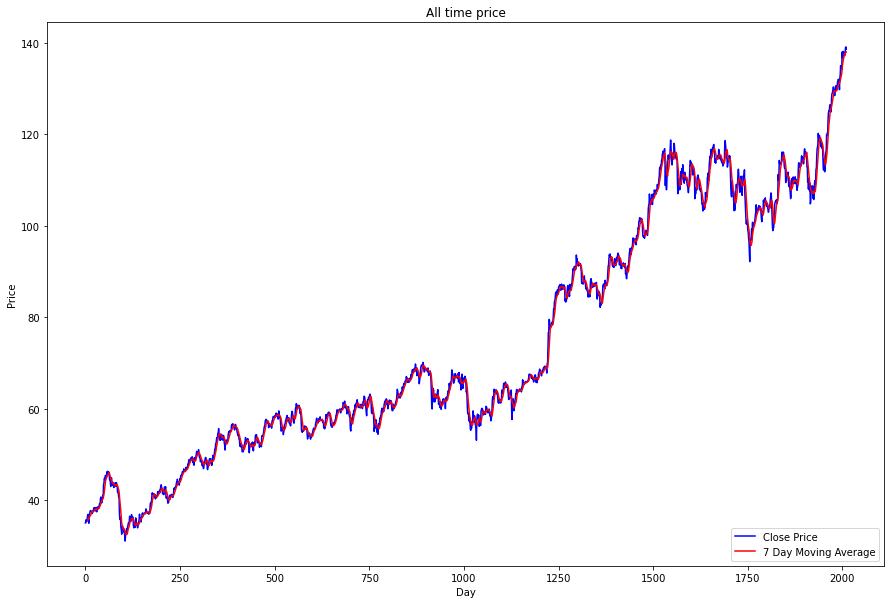

In [28]:
plt.figure(figsize=(15,10))
plt.plot(range(len(jpm_data)), jpm_data['Close'],'b',label='Close Price')
plt.plot(range(len(jpm_data)), jpm_data['7_Day_MA'],'r',label='7 Day Moving Average')
plt.legend(loc="lower right")
plt.xlabel('Day')
plt.ylabel('Price')
plt.title("All time price")
plt.show()

In [29]:
# Converting date column to datetime so we can aggregate/filter by date
jpm_data['Date'] = jpm_data['Date'].apply(pd.to_datetime)

In order to better see the moving averages, we can plot a subset of the data.

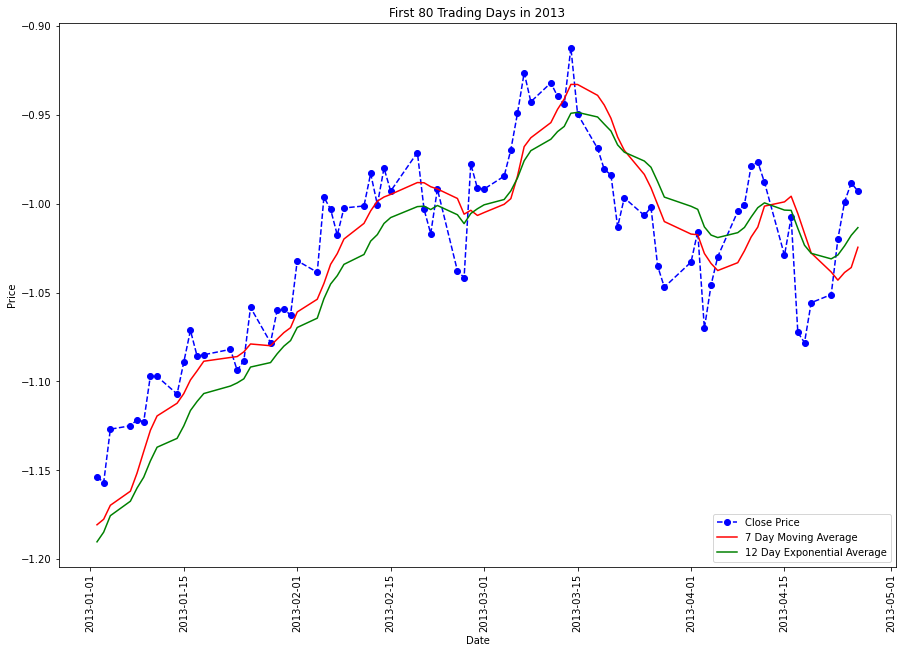

In [68]:
twenty_thirteen_data_first_eighty = jpm_data.loc[(jpm_data['Date'].dt.year == 2013)][:80]
plt.figure(figsize=(15,10))
plt.plot(twenty_thirteen_data_first_eighty['Date'], twenty_thirteen_data_first_eighty['Close'],'b', label='Close Price',linestyle='--',marker='o')
plt.plot(twenty_thirteen_data_first_eighty['Date'], twenty_thirteen_data_first_eighty['7_Day_MA'],'r', label='7 Day Moving Average')
plt.plot(twenty_thirteen_data_first_eighty['Date'], twenty_thirteen_data_first_eighty['12_Day_EMA'],'g', label='12 Day Exponential Average')
plt.legend(loc="lower right")
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=90)
plt.title("First 80 Trading Days in 2013")
plt.show()

Another interesting visualization we can make is one that visualizes which year yielded the highest returns. We have an attribute called "Daily Change" which is the difference between the previous day's and current day's close price. In aggregating the data by year and summing up all the values in this column, we can see which year had the highest returns.

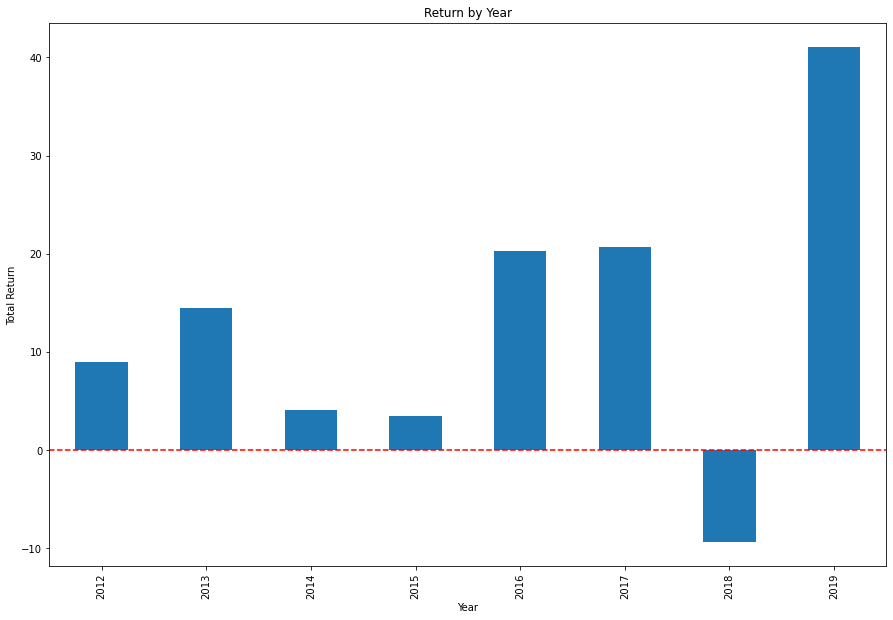

In [31]:
plt.figure(figsize=(15,10))
jpm_data.groupby(jpm_data.Date.dt.year)['Daily_Change'].sum().plot(kind='bar')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Total Return')
plt.title("Return by Year")
plt.show()

From the graph above, we can see that the year with the best returns was 2019 with 2018 actually being an overall negative year for JP Morgan. The code below confirms these results.

In [32]:
twenty_eighteen_data = jpm_data.loc[(jpm_data['Date'].dt.year == 2018)]
twenty_nineteen_data = jpm_data.loc[(jpm_data['Date'].dt.year == 2019)]
print("Total return for 2018 :: ", twenty_eighteen_data.iloc[len(twenty_eighteen_data) - 1]['Close'] - twenty_eighteen_data.iloc[0]['Close'])
print("Total return for 2019 :: ", twenty_nineteen_data.iloc[len(twenty_nineteen_data) - 1]['Close'] - twenty_nineteen_data.iloc[0]['Close'])

Total return for 2018 ::  -10.329994
Total return for 2019 ::  39.32000700000002


The plot below shows which day of the week had the highest returns. Looking at the [dt.dayofweek docs](https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.dayofweek.html), we see that 0 represents Monday. Our dayofweek ranging only from 0 to 4 makes sense since the stock market is closed on weekends and trading only occurs on week-days.

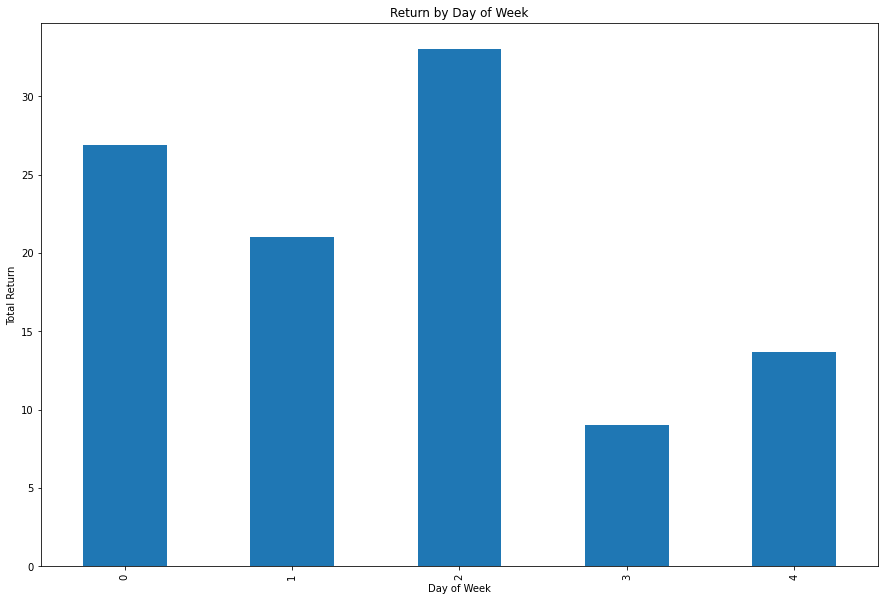

In [33]:
plt.figure(figsize=(15,10))
jpm_data.groupby(jpm_data.Date.dt.dayofweek)['Daily_Change'].sum().plot(kind='bar')
plt.title("Return by Day of Week")
plt.xlabel('Day of Week')
plt.ylabel('Total Return')
plt.show()

The plot below is the average volume by day of week. All the days have a fairly similar average volume, however, Friday does have the highest volume on average and Monday the lowest. 

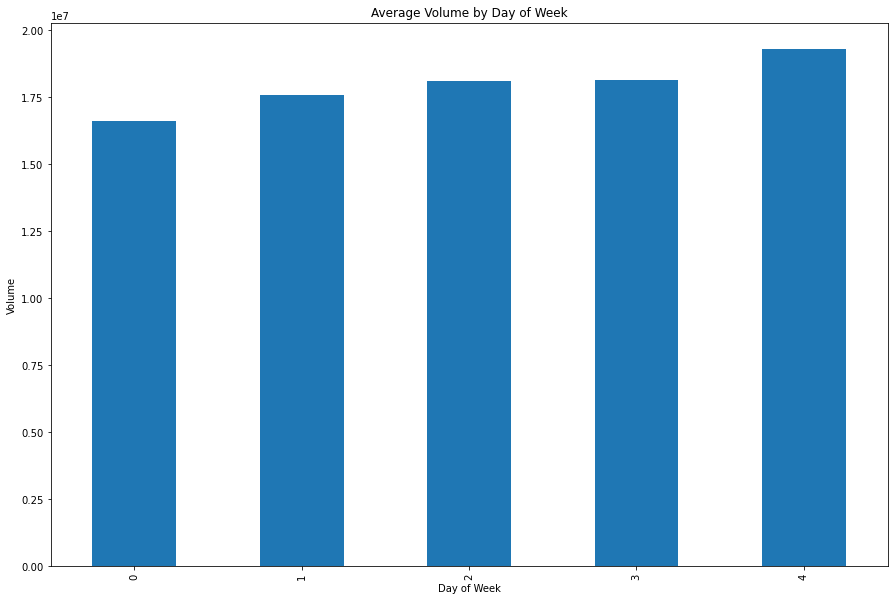

In [34]:
plt.figure(figsize=(15,10))
jpm_data.groupby(jpm_data.Date.dt.dayofweek)['Volume'].mean().plot(kind='bar')
plt.title("Average Volume by Day of Week")
plt.xlabel('Day of Week')
plt.ylabel('Volume')
plt.show()

The plot below visualizes the daily close price on top and the daily volume on the bottom of the first 80 days of trading in 2013 to see if there is any noticeable pattern. There doesn't seem to be any direct relation apart from the day that the stock hit it's peak, the volume was far greater than the rest of the days. This could possibly be due to external factors such as positive news or earnings leading to positive market sentiment.

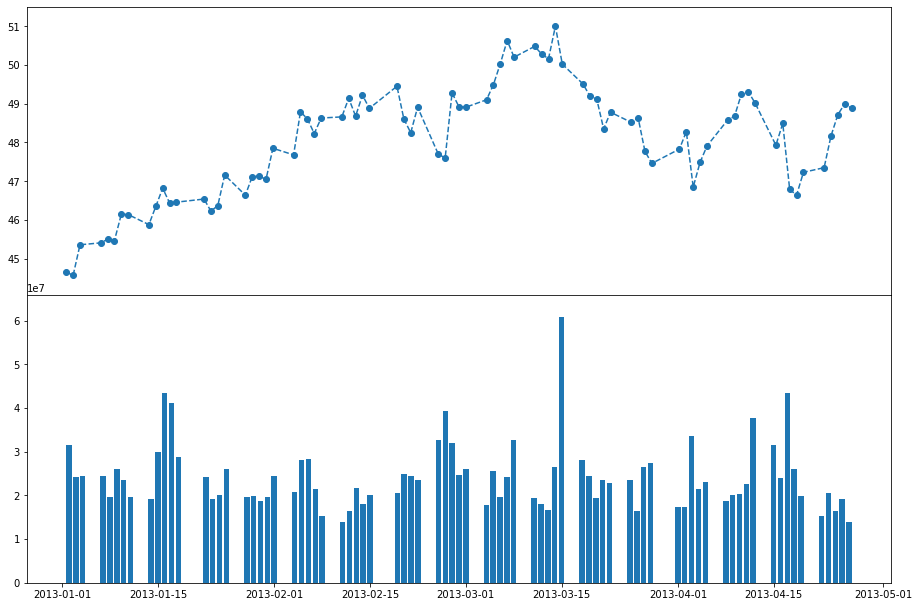

In [35]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_axes([0.1, 0.5, 0.8, 0.4],
                   xticklabels=[], 
                   ylim=
                   (twenty_thirteen_data_first_eighty['Close'].min()-.5, twenty_thirteen_data_first_eighty['Close'].max()+.5))
ax2 = fig.add_axes([0.1, 0.1, 0.8, 0.4],
                   ylim=(0,twenty_thirteen_data_first_eighty['Volume'].max()+ 5000000))

ax1.plot(twenty_thirteen_data_first_eighty['Date'], twenty_thirteen_data_first_eighty['Close'],linestyle='--',marker='o')
ax2.bar(twenty_thirteen_data_first_eighty['Date'], twenty_thirteen_data_first_eighty['Volume'], label="Volume");

The overall goal of this project is to determine if the next trading day's high will be greater than the current day's high. This attribute was encoded under the 'Next_High' column. The graph below visualizes the distribution of 'Next_High' by year counting how many times the next day's high was greater or lower than the current day's high for each year. As seen, 2019 has the highest number of next day highs being greater which is consistent with 2019 also having the greatest returns. Another thing to note, there is a fairly small difference between the counts of next high meaning a model that just guesses one of them
would do fairly bad since there isn't one value that is overwhelmingly more common.

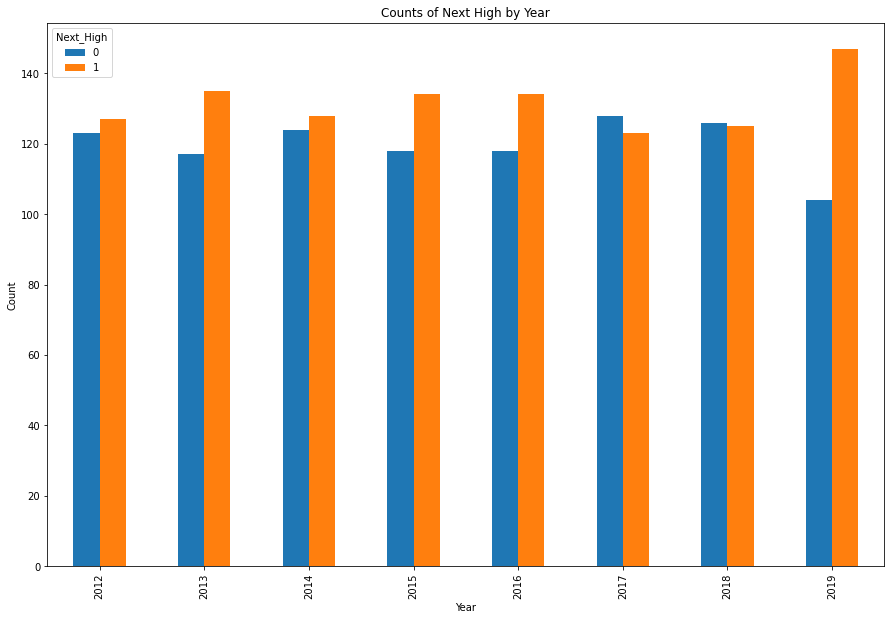

In [36]:
next_high_counts_yearly = jpm_data.groupby(jpm_data.Date.dt.year)['Next_High'].value_counts().unstack()

next_high_counts_yearly.plot.bar(figsize=(15, 10))
plt.title("Counts of Next High by Year")
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

The plot below shows how the stock price relates to the momentum indicator. Knowing that 7 day momentum is calculated by simply finding the difference between the closing price of the stock today and the closing price a week ago, is it expected that momentum closely follows the movement of the actual stock. In sharp price rises we see the momentum shoot above 0 while in rapid decreases we see it dip below 0.

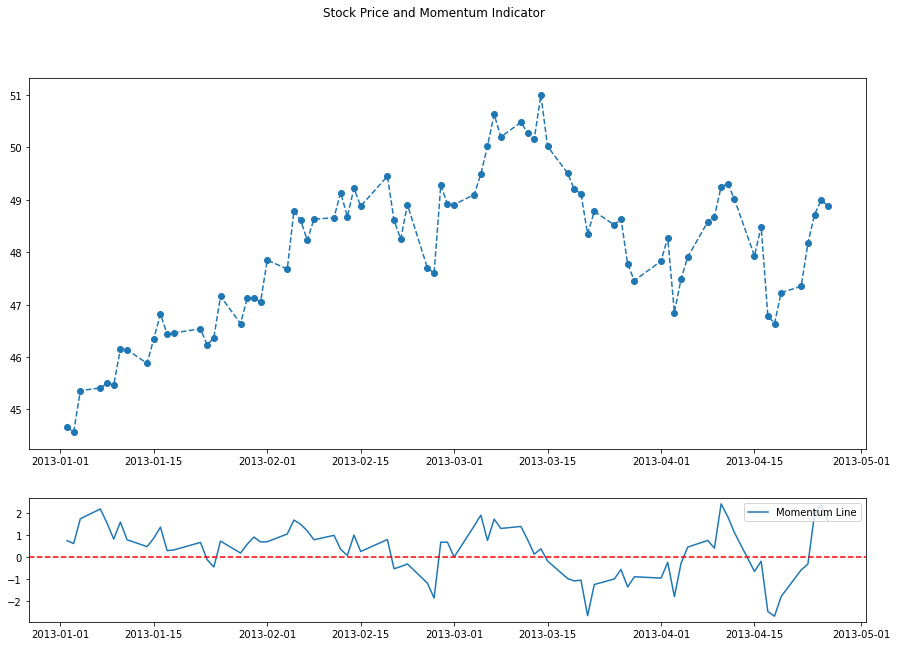

<Figure size 1080x720 with 0 Axes>

In [37]:
fig, axs = plt.subplots(2,figsize=(15,10), gridspec_kw={'height_ratios': [3, 1]})
plt.figure(figsize=(15,10))
fig.suptitle('Stock Price and Momentum Indicator')
axs[0].plot(twenty_thirteen_data_first_eighty['Date'], twenty_thirteen_data_first_eighty['Close'],linestyle='--',marker='o')
axs[1].plot(twenty_thirteen_data_first_eighty['Date'], twenty_thirteen_data_first_eighty['7_Day_MOM'], label="Momentum Line")
axs[1].legend(loc="upper right")
axs[1].axhline(y=0, color='r', linestyle='--')

The plot below shows how stock price correlates to the MACD indicator. Since the MACD is a momentum indicator, a sharp sell off results in the signal line being much higher than the MACD line which is a strong indicator of bearish movements. This is seen below in the time period between 2013-3-15 and 2013-4-01 where $JPM expierenced a rapid price drop.

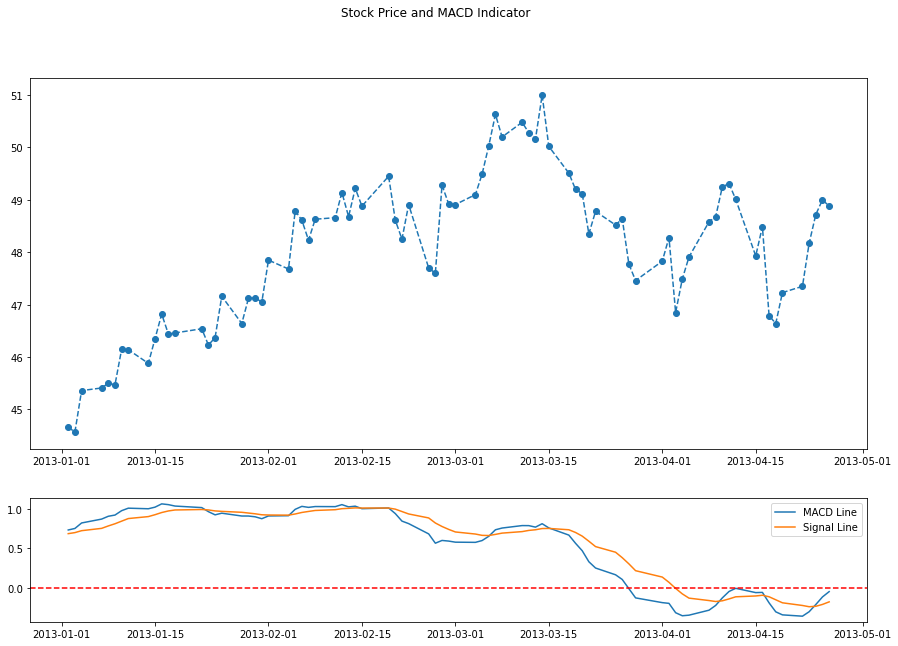

<Figure size 1080x720 with 0 Axes>

In [38]:
fig, axs = plt.subplots(2,figsize=(15,10), gridspec_kw={'height_ratios': [3, 1]})
plt.figure(figsize=(15,10))
fig.suptitle('Stock Price and MACD Indicator')
axs[0].plot(twenty_thirteen_data_first_eighty['Date'], twenty_thirteen_data_first_eighty['Close'],linestyle='--',marker='o')
axs[1].plot(twenty_thirteen_data_first_eighty['Date'], twenty_thirteen_data_first_eighty['MACD'], label="MACD Line")
axs[1].plot(twenty_thirteen_data_first_eighty['Date'], twenty_thirteen_data_first_eighty['MACD_Signal'], label="Signal Line")
axs[1].legend(loc="upper right")
axs[1].axhline(y=0, color='r', linestyle='--')

The plot below visualizes the stochastic oscillator indicator's movement in relation to the stock price movement. As mentioned before, it is a bounded oscillator where a value over 80 represents overbuying of the stock while a value under 20 represents underbuying.

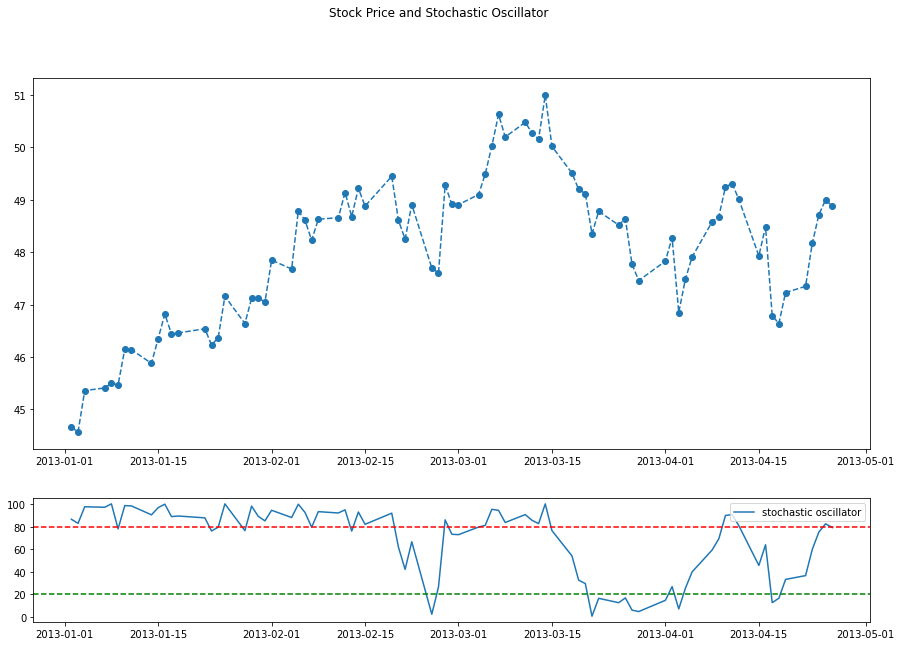

<Figure size 1080x720 with 0 Axes>

In [39]:
fig, axs = plt.subplots(2,figsize=(15,10), gridspec_kw={'height_ratios': [3, 1]})
plt.figure(figsize=(15,10))
fig.suptitle('Stock Price and Stochastic Oscillator')
axs[0].plot(twenty_thirteen_data_first_eighty['Date'], twenty_thirteen_data_first_eighty['Close'],linestyle='--',marker='o')
axs[1].plot(twenty_thirteen_data_first_eighty['Date'], twenty_thirteen_data_first_eighty['Sto_Ocs'], label="stochastic oscillator")
axs[1].legend(loc="upper right")
axs[1].axhline(y=80, color='r', linestyle='--')
axs[1].axhline(y=20, color='g', linestyle='--',label='Underbuying Level')

## II. Data Preprocessing <a id='data_preprocess'></a>

### Removing Missing/Broken Values

In [40]:
jpm_data[jpm_data.isna().any(axis=1)].shape

(33, 23)

In [41]:
print("Shape before :: ", jpm_data.shape)
jpm_data = jpm_data.dropna()
print("Shape after :: ", jpm_data.shape)

Shape before ::  (2011, 23)
Shape after ::  (1978, 23)


As we can see, the first 33 rows were dropped since they contained NAN values.

Next, delete the last row since it's Next_High is incorrect as there is no next day to look at.

In [42]:
print("Shape before :: ", jpm_data.shape)
jpm_data.drop(jpm_data.tail(1).index,inplace=True)
print("Shape after :: ", jpm_data.shape)

Shape before ::  (1978, 23)
Shape after ::  (1977, 23)


### Standardizing Input Attributes

#### Before Standardization

In [43]:
jpm_data.describe()

,Open,High,Low,Close,Adj Close,Volume,Prev_Close,Daily_Change,Daily_Change_Percent,H_L_Diff,...,MA_Trend,7_Day_MOM,MOM_Trend,12_Day_EMA,26_Day_EMA,MACD,MACD_Signal,MACD_Trend,MACD_Signal_Diff,Sto_Ocs
count,1977.000000,1977.000000,1977.000000,1977.000000,1977.000000,1.977000e+03,1977.000000,1977.000000,1977.000000,1977.000000,...,1977.000000,1977.000000,1977.000000,1977.000000,1977.000000,1977.000000,1977.000000,1977.000000,1977.000000,1977.000000
mean,74.953475,75.568821,74.350733,74.973510,66.311459,1.773149e+07,74.922590,0.050921,0.000742,1.218088,...,0.574608,0.252964,0.574102,74.697185,74.357679,0.339506,0.335650,0.518968,0.003856,59.294610
std,26.284533,26.474409,26.116623,26.286393,26.890453,1.073842e+07,26.259523,1.001127,0.013512,0.782670,...,0.494527,2.249845,0.494603,26.094471,25.894120,1.054452,0.976279,0.499766,0.346213,29.918474
min,30.889999,32.130001,30.830000,31.000000,24.277533,3.324300e+06,31.000000,-5.479996,-0.092784,0.229999,...,0.000000,-11.869995,0.000000,33.250015,34.896140,-3.772427,-3.117570,0.000000,-1.036991,0.000000
25%,55.970001,56.500000,55.500000,56.020000,46.255539,1.179740e+07,56.000000,-0.430000,-0.006152,0.739998,...,0.000000,-0.899998,0.000000,56.368671,56.308675,-0.201911,-0.194837,0.000000,-0.198195,33.185863
50%,64.260002,64.820000,63.709999,64.330002,56.147377,1.508160e+07,64.269997,0.040001,0.000588,1.020000,...,1.000000,0.320000,1.000000,64.112554,63.878892,0.396492,0.385798,1.000000,0.011864,66.774129
75%,101.760002,102.419998,100.730003,101.410004,94.371429,2.028720e+07,101.410004,0.539997,0.007949,1.440003,...,1.000000,1.500000,1.000000,101.996696,101.826609,0.835801,0.834254,1.000000,0.206388,85.942433
max,139.300003,139.770004,138.669998,139.139999,133.304199,2.172942e+08,139.039993,4.979996,0.083286,12.849998,...,1.000000,9.630005,1.000000,137.201752,134.792502,3.362353,3.122355,1.000000,1.374906,100.000000


In [44]:
# defining input columns
feature_columns = ['Open','High','Low','Close','Volume','Prev_Close', 'Daily_Change', 'Daily_Change_Percent', 'H_L_Diff','7_Day_MA', 'MA_Trend', '7_Day_MOM', 'MOM_Trend',
       '12_Day_EMA', '26_Day_EMA', 'MACD', 'MACD_Signal', 'MACD_Trend','MACD_Signal_Diff', 'Sto_Ocs']
target_column = ['Next_High']

In [45]:
scaler = StandardScaler()
jpm_data[feature_columns] = scaler.fit_transform(jpm_data[feature_columns])

#### After Standardization

In [46]:
jpm_data.describe()

,Open,High,Low,Close,Adj Close,Volume,Prev_Close,Daily_Change,Daily_Change_Percent,H_L_Diff,...,MA_Trend,7_Day_MOM,MOM_Trend,12_Day_EMA,26_Day_EMA,MACD,MACD_Signal,MACD_Trend,MACD_Signal_Diff,Sto_Ocs
count,1.977000e+03,1977.000000,1.977000e+03,1.977000e+03,1977.000000,1.977000e+03,1.977000e+03,1.977000e+03,1977.000000,1.977000e+03,...,1.977000e+03,1977.000000,1.977000e+03,1.977000e+03,1.977000e+03,1.977000e+03,1977.000000,1.977000e+03,1.977000e+03,1.977000e+03
mean,2.875236e-16,0.000000,-2.300189e-16,1.150094e-16,66.311459,-2.012665e-16,-3.450283e-16,-1.797023e-18,0.000000,-1.150094e-16,...,4.762110e-17,0.000000,5.031663e-17,5.750472e-17,-4.600378e-16,-1.437618e-17,0.000000,2.425981e-17,3.594045e-18,-3.090879e-16
std,1.000253e+00,1.000253,1.000253e+00,1.000253e+00,26.890453,1.000253e+00,1.000253e+00,1.000253e+00,1.000253,1.000253e+00,...,1.000253e+00,1.000253,1.000253e+00,1.000253e+00,1.000253e+00,1.000253e+00,1.000253,1.000253e+00,1.000253e+00,1.000253e+00
min,-1.676827e+00,-1.641200,-1.666821e+00,-1.673285e+00,24.277533,-1.341989e+00,-1.673058e+00,-5.526089e+00,-6.923592,-1.262779e+00,...,-1.162228e+00,-5.389715,-1.161026e+00,-1.588753e+00,-1.524343e+00,-3.900580e+00,-3.538020,-1.038684e+00,-3.007140e+00,-1.982374e+00
25%,-7.224126e-01,-0.720456,-7.219732e-01,-7.212213e-01,46.255539,-5.527438e-01,-7.207815e-01,-4.805008e-01,-0.510346,-6.109998e-01,...,-1.162228e+00,-0.512592,-1.161026e+00,-7.025684e-01,-6.972074e-01,-5.135876e-01,-0.543514,-1.038684e+00,-5.837510e-01,-8.728838e-01
50%,-4.069381e-01,-0.406111,-4.075346e-01,-4.050081e-01,56.147377,-2.468301e-01,-4.057685e-01,-1.091005e-02,-0.011372,-2.531568e-01,...,8.604167e-01,0.029803,8.613073e-01,-4.057300e-01,-4.047806e-01,5.405695e-02,0.051379,9.627568e-01,2.313728e-02,2.500599e-01
75%,1.020117e+00,1.014488,1.010312e+00,1.005965e+00,94.371429,2.380566e-01,1.008934e+00,4.886495e-01,0.533534,2.836076e-01,...,8.604167e-01,0.554417,8.613073e-01,1.046445e+00,1.061086e+00,4.707857e-01,0.510848,9.627568e-01,5.851415e-01,8.909066e-01
max,2.448695e+00,2.425641,2.463394e+00,2.441671e+00,133.304199,1.858869e+01,2.442300e+00,4.924773e+00,6.110689,1.486560e+01,...,8.604167e-01,4.168915,8.613073e-01,2.395924e+00,2.334511e+00,2.867474e+00,2.855137,9.627568e-01,3.961143e+00,1.360888e+00


Standardization was successful as the mean of all the input columns is 0 or extremely close to 0 and the standard deviation is 1 or extremely close to 1.

### Splitting Data into Training and Testing

The first 70% of rows will be used for training the models while the last 30% of rows will be used to test the model's performance.

In [47]:
train_X = jpm_data[feature_columns].iloc[:int(len(jpm_data)*(70/100))]
train_Y = jpm_data[target_column].iloc[:int(len(jpm_data)*(70/100))]
test_X = jpm_data[feature_columns].iloc[int(len(jpm_data)*(70/100)):]
test_Y = jpm_data[target_column].iloc[int(len(jpm_data)*(70/100)):]
train_X.shape,train_Y.shape,test_X.shape,test_Y.shape, len(train_X)/len(jpm_data), len(test_X)/len(jpm_data)

((1383, 20),
 (1383, 1),
 (594, 20),
 (594, 1),
 0.6995447647951442,
 0.30045523520485584)

Printing the shapes of the testing and training input and output sets shows that they are of correct dimensions. There are 20 input columns and 1 target column.

## III. Training Models <a id='data_training'></a>

### Linear Model (Logistic Regression) <a id='lin_model'></a>

In [48]:
%%capture
logistic_model = LogisticRegression()

best_logistic = GridSearchCV(logistic_model, {
  'tol': [1e-6,1e-4],  
  'C': [.1, .5, 1, 10],
  'solver': ['newton-cg', 'lbfgs','liblinear', 'sag', 'saga'],
  'max_iter':[100,200,500,1000]
})

best_logistic.fit(train_X, train_Y.values.ravel())

In [49]:
print(best_logistic.best_estimator_)

LogisticRegression(C=10, solver='newton-cg', tol=1e-06)


In [50]:
logistic_predictions = best_logistic.best_estimator_.predict(test_X)

### Random Forest Model <a id='random_forest_model'></a>

In [51]:
random_forest_model = RandomForestClassifier()

best_random_forest = GridSearchCV(random_forest_model, {
  'n_estimators': [50,100,150],
  'max_features': ['auto', 'sqrt', 'log2'],
})

best_random_forest.fit(train_X, train_Y.values.ravel())

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [50, 100, 150]})

In [52]:
print(best_random_forest.best_estimator_)

RandomForestClassifier(max_features='log2', n_estimators=150)


In [53]:
random_forest_predictions = best_random_forest.best_estimator_.predict(test_X)

### Neural Network <a id='neural_network_model'></a>

In [54]:
nn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation=tf.nn.relu, 
                          input_shape=(len(feature_columns),)),
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(8, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

nn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1344      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 4,097
Trainable params: 4,097
Non-trainable params: 0
_________________________________________________________________


In [55]:
nn_model.compile(
    loss='binary_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)

nn_history = nn_model.fit(train_X, train_Y, epochs=600, verbose=0, batch_size=64)

In [56]:
nn_predictions= nn_model.predict(test_X)
nn_final_predictions = [round(x[0]) for x in nn_predictions]

## IV. Measuring Performance <a id='data_perfor'></a>

### ROC Curves <a id='roc_curves'></a>

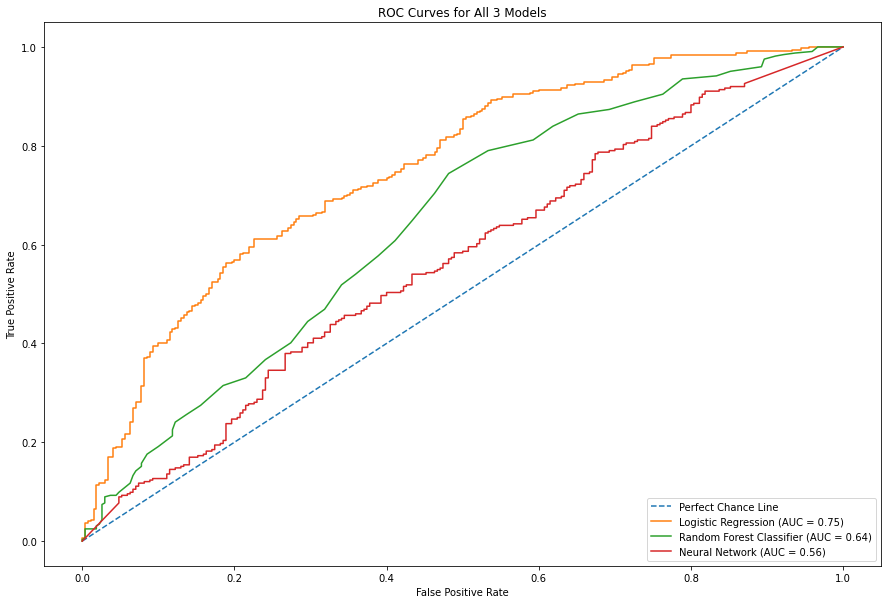

In [57]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot()
plt.plot([0, 1], ls="--", label='Perfect Chance Line')

logis_disp = plot_roc_curve(best_logistic, test_X, test_Y, name='Logistic Regression', ax=ax)
random_forest_disp = plot_roc_curve(best_random_forest, test_X, test_Y, name='Random Forest Classifier', ax=ax)

# calculations for the neural networks roc since it isn't part of sklearn
nn_fpr, nn_tpr, nn_thresholds = roc_curve(test_Y, nn_predictions)
nn_auc_score = roc_auc_score(test_Y, nn_predictions)
plt.plot(nn_fpr, nn_tpr, label=f'Neural Network (AUC = {nn_auc_score:.2f})')

plt.legend(loc='lower right')
plt.title("ROC Curves for All 3 Models")
plt.show()

### Confusion Matrices And Accuracy <a id='conf_matrix'></a>

In [58]:
from sklearn.metrics import confusion_matrix

logis_full_conf_matrix = confusion_matrix(test_Y, logistic_predictions)

rf_full_conf_matrix = confusion_matrix(test_Y, random_forest_predictions)

nn_full_conf_matrix = confusion_matrix(test_Y, nn_final_predictions)

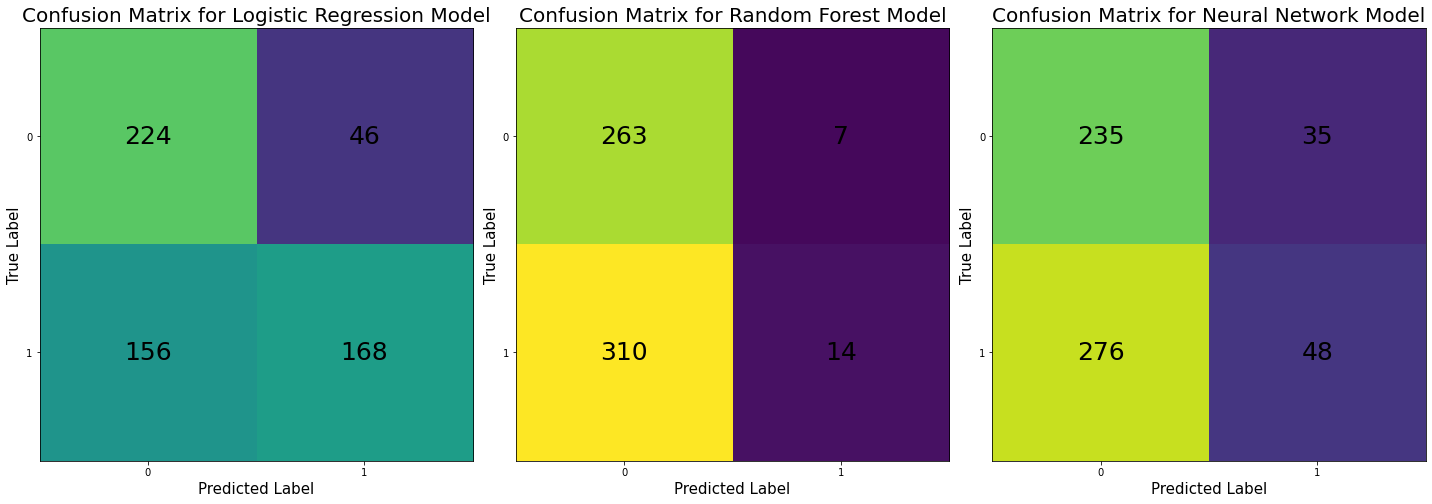

In [59]:
# logistic regression
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,3,1)
plot = plt.imshow(logis_full_conf_matrix, interpolation='nearest',vmin=0, vmax=301)


plt.xticks([0,1])
plt.yticks([0,1])

# manually adding value labels to each quadrant
for (j,i),label in np.ndenumerate(logis_full_conf_matrix):
    ax.text(i,j,label,ha='center',va='center',size=25)
    
plt.title("Confusion Matrix for Logistic Regression Model", fontsize=20)
plt.xlabel('Predicted Label', fontsize=15)
plt.ylabel('True Label', fontsize=15)
plt.tight_layout()

# random forest
ax = fig.add_subplot(1,3,2)
plot = plt.imshow(rf_full_conf_matrix, interpolation='nearest',vmin=0, vmax=301)

plt.xticks([0,1])
plt.yticks([0,1])

# manually adding value labels to each quadrant
for (j,i),label in np.ndenumerate(rf_full_conf_matrix):
    ax.text(i,j,label,ha='center',va='center',size=25)
    
plt.title("Confusion Matrix for Random Forest Model", fontsize=20)
plt.xlabel('Predicted Label', fontsize=15)
plt.ylabel('True Label', fontsize=15)
plt.tight_layout()

# neural network
ax = fig.add_subplot(1,3,3)
plot = plt.imshow(nn_full_conf_matrix, interpolation='nearest',vmin=0, vmax=301)
plt.xticks([0,1])
plt.yticks([0,1])

# manually adding value labels to each quadrant
for (j,i),label in np.ndenumerate(nn_full_conf_matrix):
    ax.text(i,j,label,ha='center',va='center',size=25)
    
plt.title("Confusion Matrix for Neural Network Model", fontsize=20)
plt.xlabel('Predicted Label', fontsize=15)
plt.ylabel('True Label', fontsize=15)
plt.tight_layout()
plt.show()

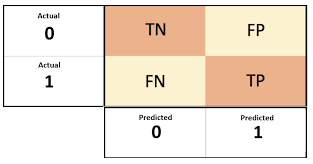

In [60]:
print("Accuracy of logistic regression :: ", accuracy_score(test_Y, logistic_predictions))
print("Accuracy of random forest classifier :: ", accuracy_score(test_Y, random_forest_predictions))
print("Accuracy of neural network :: ", accuracy_score(test_Y, nn_final_predictions))

Accuracy of logistic regression ::  0.6599326599326599
Accuracy of random forest classifier ::  0.4663299663299663
Accuracy of neural network ::  0.4764309764309764


Looking at the confusion matrices for the 3 models, only the logistic regression model has a relatively high amount of true positives. While all models have high counts of true negatives, the random forest and neural network models have a hard time at correctly predicting that the next day's high will be greater than the current day's high. Both the random forest and neural network models have low counts of true positives. Looking at the accuracies of the 3 models, we see that the logistic regression model is the most accurate at 66%. This is also confirmed by the ROC curve and AUC scores in which the logistic regression model has the highest AUC score giving it the best predictive accuracy.

## V. Assessing Interpretability <a id='data_interp'></a>

### Visualizing Logistic Regression Model Coefficients <a id='feature_coeff'></a>

In [61]:
# creating a df to store feature name and its coefficient in the logistic regression model
# sorting the df by abs value of coeffcient for plotting
logis_coef_df = pd.DataFrame()
logis_coef_df['feature_name'] = feature_columns
logis_coef_df['feature_coef'] = best_logistic.best_estimator_.coef_[0]
logis_coef_df = logis_coef_df.reindex(logis_coef_df.feature_coef.abs().sort_values(ascending=False).index)

In [62]:
# Pair the coefficients with feature names
for i in range(len(logis_coef_df)):
    print('{0:22}:  {1}'.format(logis_coef_df['feature_name'].iloc[i], logis_coef_df['feature_coef'].iloc[i]))
    print('------------------------------------------')

Low                   :  -9.301279494177336
------------------------------------------
High                  :  -9.190169310979323
------------------------------------------
Open                  :  -8.427160641722491
------------------------------------------
7_Day_MA              :  5.855678323335241
------------------------------------------
26_Day_EMA            :  5.6480996117666304
------------------------------------------
12_Day_EMA            :  5.610844572468814
------------------------------------------
Close                 :  4.833227804007602
------------------------------------------
Prev_Close            :  4.81943784078776
------------------------------------------
H_L_Diff              :  -0.4935545363134494
------------------------------------------
Daily_Change          :  0.4914341624801648
------------------------------------------
7_Day_MOM             :  0.3332920522932314
------------------------------------------
Sto_Ocs               :  0.30841199757893867
--

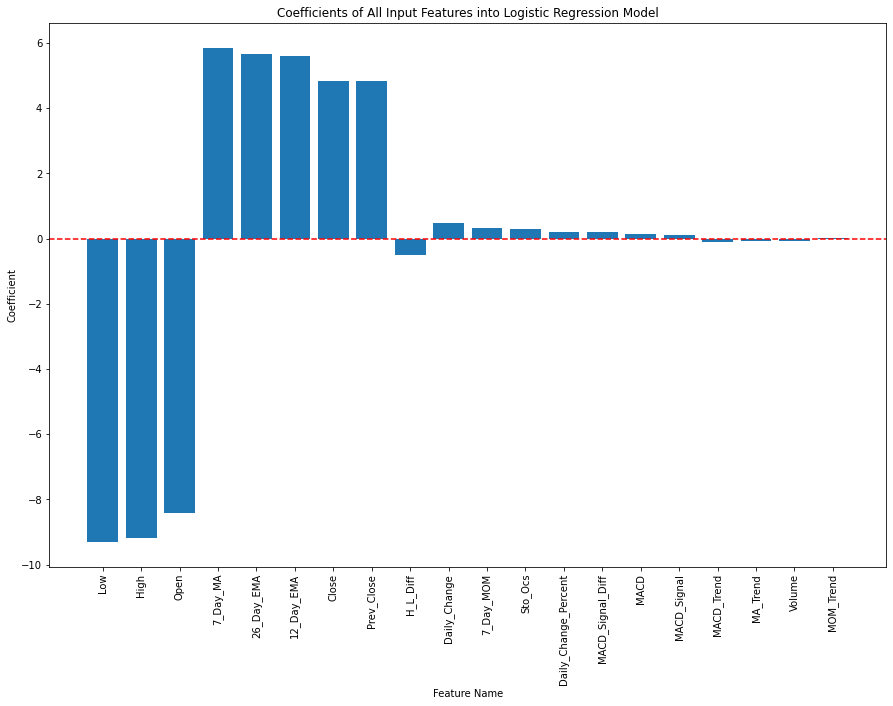

In [63]:
fig = plt.figure(figsize=(15, 10))
plt.bar(logis_coef_df['feature_name'], logis_coef_df['feature_coef'])
plt.axhline(y=0, color='r', linestyle='--')
plt.xticks(rotation=90)
plt.title("Coefficients of All Input Features into Logistic Regression Model")
plt.xlabel('Feature Name')
plt.ylabel('Coefficient')
plt.show()

According to the model's feature coefficients as seen above, the most significant features for the logistic regression model were the stock's low price, high price, open price, 7 day simple moving average, 26 day exponential moving average, 12 day exponential moving average, close price, and the previous day's close price.   

### Visualizing Random Forest Model Feature Importances

In [64]:
best_random_forest.best_estimator_.feature_importances_
random_forest_coef_df = pd.DataFrame()
random_forest_coef_df['feature_name'] = feature_columns
random_forest_coef_df['feature_coef'] = best_random_forest.best_estimator_.feature_importances_
random_forest_coef_df = random_forest_coef_df.reindex(random_forest_coef_df.feature_coef.abs().sort_values().index)

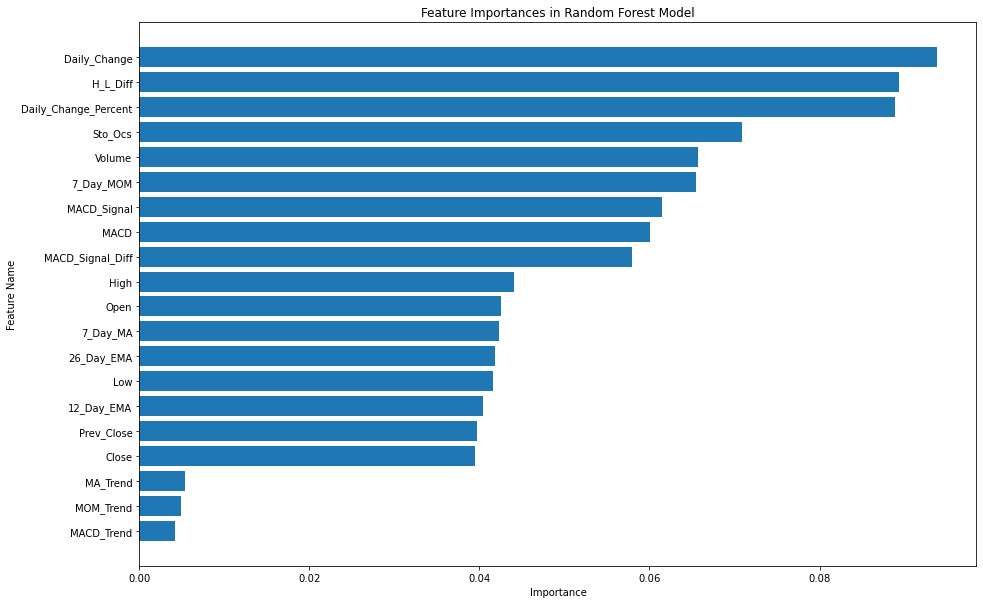

In [65]:
fig = plt.figure(figsize=(15, 10))
plt.barh(random_forest_coef_df['feature_name'], random_forest_coef_df['feature_coef'])
plt.title("Feature Importances in Random Forest Model")
plt.xlabel('Importance')
plt.ylabel('Feature Name')
plt.show()

Looking at the feature importances for the random forest model, we see that the daily high-low difference was the most important followed by the day's change in close from yesterday's close in both percent and dollar amounts. It's interesting to note that the variables that were most significant in the logistic regression are ranked fairly low in the random forest model, such as for attributes low, high, and open price. Also, the daily volume of the stock is the 6th most significant variable in the random forest model while extremely insignificant in the logistic regression model.

### Shapley Plot of Best Performing Model <a id='shapley_plots'></a>

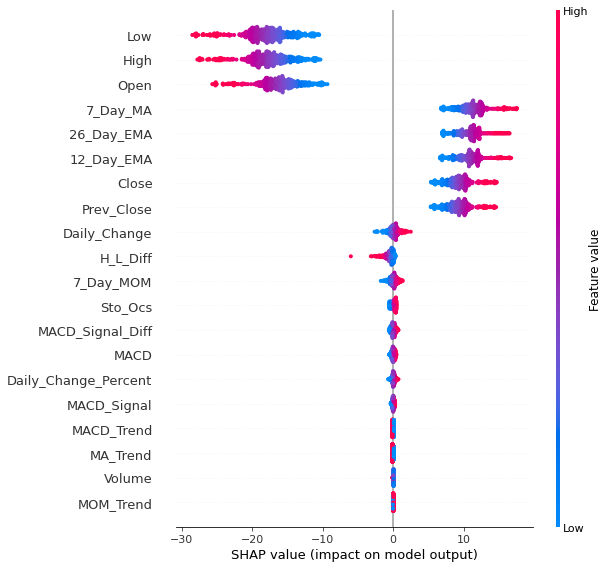

In [66]:
logis_explainer = shap.Explainer(best_logistic.best_estimator_, train_X)
shap_values = logis_explainer(test_X)
shap.summary_plot(shap_values)

In [67]:
shap.initjs()
shap.plots.force(shap_values[0])

The above shapley beeswarm plot is in line with the coefficients returned from the logistic regression model itself. Low, high, and open all have high negative shap values which means that those values bring down the value of the prediction. The 7 day simple moving average, 26 day exponential moving average, 12 day exponential moving average, close and previous close price all bring the value of the prediction up. This is directly inline with the bar graph displaying the coefficients where the features with negative shapley values also have high negative coefficients. The force plot shows how those features are essentially engaged in a tug of war against eachother, directly impacting the predicted value. The most prominent features in the force plot are also the most prominent global features.

## Conclusion <a id='conclusion'></a>

Using over 7 years of daily stock data, 3 machine learning models were trained in order to predict if JP Morgan's high price would increase or decrease the following trading day. The performance of these models is definitely not good enough to excite the average day trader. The best performing model, the logistic regression, acheived an accuracy of 65% with the random forest and neural networks hovering around 50% accuracy. A key observation is that the random forest and neural network really struggled in predicting the high price being greater the following day. Looking at the confusion matrices, both models had far lower rates of true positives than the logistic regression model while still having similar true negative rates. Furthermore, the majority of the manually encoded features such as stochastic oscillator, momentum, and the moving average convergence divergence indicators played minimal roles in the best performing model. Assessing the coefficients of the logistic regression model, we saw that those features also ranked fairly low in terms of importance within the model. <br> <br>
In future projects, I hope to implement more technical indicators, possibly ones that include the stock's volume. None of the indicators implemented in this project depended on volume and that future project may shed light on the relationship between volume and price. Furthermore, I want to test the performance of the models if they were to be trained without the low impact features. Seeing as many features in the models had low impact on the prediction, would those models be improved if those features were to be entirely omitted during model training?  